#### Notebook to create time-pressure series from TC output

Assumes key integrated variables have been processed and written out by PE_write.py to single-level netcdf files.

James Ruppert  
jruppert@ou.edu  
1/8/23

In [36]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import subprocess
import sys
import pandas as pd

#### Main settings

In [37]:
# NOTE: Using copied tracking from CTL for NCRF tests

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 4

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_pres/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

In [38]:
def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

In [39]:
# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Get Lat/Lon
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
process = subprocess.Popen(['ls '+datdir+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()
lon1d=lon[0,:]
lat1d=lat[:,0]

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/post/d02/'
varfil_main = Dataset(datdir+'T.nc')
nz = varfil_main.dimensions['level'].size
pres = varfil_main.variables['pres'][:] # hPa

In [40]:
# Create arrays

nt = np.zeros(ntest, dtype=np.int32)

for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()

    nt[itest]=i_nt

avor_t0 = np.zeros((nmem,nt[0],nz))
thvp_t0 = np.zeros((nmem,nt[0],nz))

avor_t1 = np.zeros((nmem,nt[1],nz))
thvp_t1 = np.zeros((nmem,nt[1],nz))

#### Main loop

In [41]:
for itest in range(ntest):

    print('Running test: ',tests[itest])

    for imemb in range(nmem):

        print('Running imemb: ',memb_all[imemb])

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

        # Read variables

        # AVOR
        varfil_main = Dataset(datdir+'time_pres_avor.nc')
        avor = varfil_main.variables['avor'][:,:] # 10^-5 /s
        pres = varfil_main.variables['pres'][:] # Pa
        varfil_main.close()

        # THV'
        varfil_main = Dataset(datdir+'time_pres_thvp.nc')
        thvp = varfil_main.variables['thvp'][:,:] # K
        varfil_main.close()

        t0=0
        t1=nt[itest]

        if itest == 0:
            avor_t0[imemb,:] = avor
            thvp_t0[imemb,:] = thvp
        elif itest == 1:
            avor_t1[imemb,:] = avor
            thvp_t1[imemb,:] = thvp

Running test:  ctl
Running imemb:  memb_01
Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10
Running test:  ncrf36h
Running imemb:  memb_01
Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10


---
### Plotting routines

In [42]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

/tmp/ipykernel_28901/4032121855.py:41: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(var, axis=0)


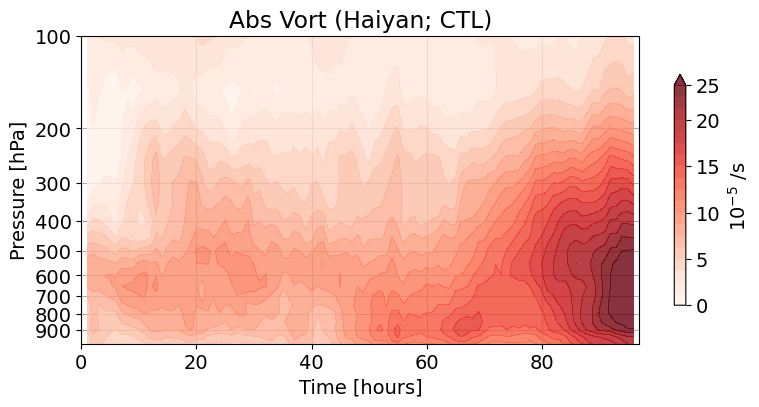

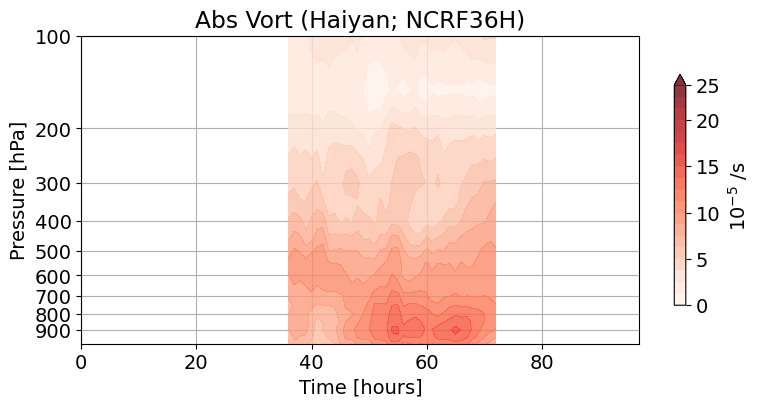

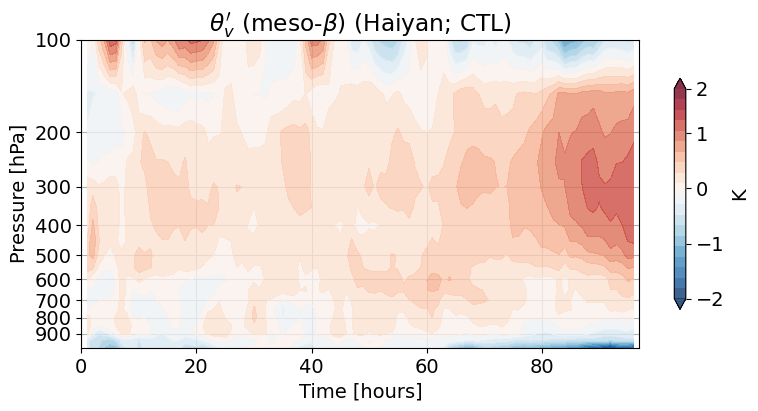

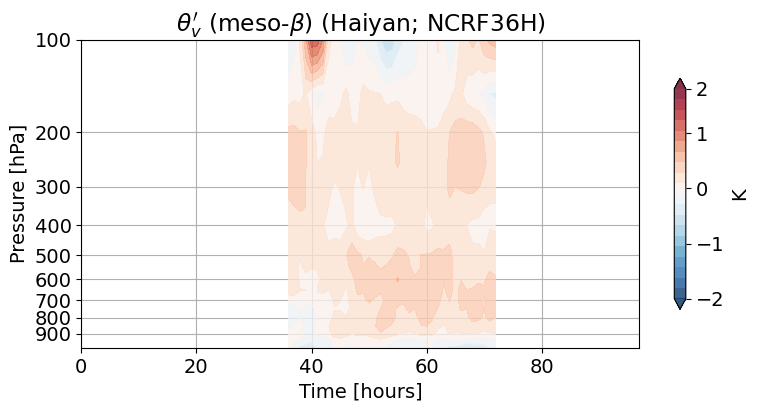

In [43]:
nvar=2
for ivar in range(nvar):
# for ivar in range(0,1):

    if ivar == 0:
        var0 = np.copy(avor_t0)
        var1 = np.copy(avor_t1)
        title_tag = 'Abs Vort'
        figtag = 'avor'
        units_var = '10$^{-5}$ /s'
        cmax=25; cmin=0
        cmap='Reds'
        extend='max'
        nlevs=20
    elif ivar == 1:
        var0 = np.copy(thvp_t0)
        var1 = np.copy(thvp_t1)
        title_tag = r"$\theta_v'$ (meso-$\beta$)"
        figtag = 'thvp'
        units_var = 'K'
        cmap='RdBu_r'
        cmax=2; cmin=-1.*cmax
        extend='both'
        nlevs=21

    # var0 = pd.DataFrame(var0)
    # var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
    # var0 = np.copy(var0)

    # var1 = pd.DataFrame(var1)
    # var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
    # var1 = np.copy(var1)

    for itest in range(ntest):

        if itest == 0:
            var = np.copy(var0)
        elif itest == 1:
            var = np.copy(var1)

        varmean = np.nanmean(var, axis=0)
        # std_t0 = np.nanstd(var, axis=0)

        tshift = get_tshift(tests[itest])
        xdim = range(0+tshift, nt[itest]+tshift)

        # create figure
        fig = plt.figure(figsize=(9,4))
        ax = fig.add_subplot(111)

        ax.set_title(title_tag+' ('+storm.capitalize()+'; '+tests[itest].upper()+')')#, fontsize=20)
        ax.set_ylabel('Pressure [hPa]')
        ax.set_xlabel('Time [hours]')

        # fill contour
        inc=(cmax-cmin)/nlevs
        clevs = np.arange(cmin, cmax, inc)
        im = ax.contourf(xdim, pres, np.transpose(varmean), clevs, cmap=cmap, alpha=0.8, \
                        extend=extend, zorder=2)

        cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
        cbar.ax.set_ylabel(units_var)

        t_range=[0,nt[0]]
        plt.xlim(t_range)

        # Pressure axis
        ax.set_yscale('log')
        ax.invert_yaxis()
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ytick_loc=np.arange(900,0,-100)
        plt.yticks(ticks=ytick_loc)
        plt.ylim(np.max(pres), 100)#np.min(pres))
        # ax.tick_params(axis='both',length=7)

        plt.grid()

        # plt.legend(loc="upper right")

        plt.savefig(figdir+'tser_'+storm+'_'+figtag+'_'+tests[itest].lower()+'.png',dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()